In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [70]:
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.tform import tform
from meshmaker.field import scalar_field, height_field, vec3_field, trace_field
from meshmaker.mesh import planargraph, trimesh
from meshmaker.geometry import slide, sintsxyp, orient2d, bbox, subdivide_triangles, loop_normal, loop_offset, loop_exterior, loop_split, loop_smooth, loop_contract, loop_area, periodic, isnear
from meshmaker.lsystem import lsystem
from meshmaker.img import perlin, proximal, normalize, segment_regions, steepness
from meshmaker.plt import plot, plot_pg, plot_loop, plot_edges, plot_edge, plot_point
from meshmaker.model import model
from meshmaker.obj import obj_world

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from functools import partial, reduce
np.seterr(invalid='raise')

{'divide': 'raise', 'over': 'warn', 'under': 'ignore', 'invalid': 'raise'}

In [6]:
def loop_equal(loop1, loop2):
    return vec3.com(loop1).isnear(vec3.com(loop2)) and len(loop1) == len(loop2)

In [7]:
from meshmaker.geometry import loop_contains

class loop_tree:
    
    @classmethod
    def bloops(cls, b, loops, loop_kws=None):
        t = cls(b)
        for i in range(len(loops)):
            loop = loops[i]
            kws = {} if loop_kws is None else loop_kws[i]
            t.av(loop, **kws)
        return t

    @property
    def piecewise_field(self):
        return lambda p: self.fp(p).field(p)

    @property
    def depth(self):
        d = 0
        p = self.parent
        while p is not None:
            d += 1
            p = p.parent
        return d
    
    def __init__(self, loop, parent=None, **kws):
        self.loop = loop
        self.parent = parent
        self.children = []
        if self.parent is not None:
            self.parent.children.append(self)
        for key, value in kws.items():
            setattr(self, key, value)
                
    def av(self, loop, **kws):
        if self.loop is not None and loop_equal(self.loop, loop):
            return loop_tree(loop, self, **kws)
        elif self.loop is None or loop_contains(self.loop, loop):
            for c in self.children:
                nv = c.av(loop, **kws)
                if nv is not None:
                    return nv
            else:
                return loop_tree(loop, self, **kws)

    def fp(self, p):
        """return most childish loop_tree which properly contains p"""
        if self.loop is None or p.inbxy(self.loop, ie=True):
            for c in self.children:
                if p.inbxy(c.loop, ie=True):
                    return c.fp(p)
            else:
                return self
        else:
            if self.parent is None:
                #print('warning: unlocated point from loop tree')
                return self
            else:
                return self.parent.fp(p)
            
    def plot(self, ax, depth=2):
        linewidth = (self.depth + 1) * 2
        color = 'k' if self.depth % 2 == 0 else 'b'
        plot_loop(ax, self.loop, lw=linewidth, col=color, mk='')
        for c in self.children:
            c.plot(ax, depth + 2)

In [8]:
def piecewise_field(loops, fields):    
    loop_kws = [dict(field=fd) for fd in fields]
    lt = loop_tree(loops.pop(0))
    lt = loop_tree.bloops(None, loops, loop_kws=loop_kws)
    def eigen(p):
        return lt.fp(p).field(p)
    return eigen

pwf = piecewise_field([vec3.O().ring(10, 8), vec3.O().ring(4, 4)],
                      [scalar_field([lambda p: -1]), scalar_field([lambda p: 1])])

In [9]:
def plot_vec3_field(ax, fd):
    ps = []
    for x in np.linspace(-500, 500, 21):
        for y in np.linspace(-500, 500, 21):
            ps.append(vec3(x, y, 0))
    a, b = bbox(ps)
    dl = max(b.x - a.x, b.y - a.y) / 100
    for p in ps:
        v = fd(p)
        v.nrmd()
        u = v.crs(vec3.Z())
        u.nrmd()
        plot_point(ax, p)
        plot_edge(ax, p - v * (dl / 1), p + v * (dl / 1), lw=2, col='b')
        plot_edge(ax, p - u * (dl / 1), p + u * (dl / 1), lw=1, col='g')
    _ = 300
    ax.set_xlim((-_, _))
    ax.set_ylim((-_, _))
    return ax

In [10]:
def percentile_mask(a, n=5):
    """set all but the n highest values in a to 0"""
    q = n * 100 / len(a)
    q = min(max(q, 100), 0)
    a[np.where(a < np.percentile(a, q))] = 0
    return a


def distribution(a, n_best=None):
    """get a useful distribution for sampling from a"""
    if n_best is not None:
        a = percentile_mask(a, n=n_best)
    if a.max() == 0:
        a += 1.0
    a /= a.sum()
    return a

In [11]:
class proceduralgraph(planargraph):    
    """a planar graph which can be procedural grown"""

    def __init__(self, fd, *ags, layer=0, **kws):
        super().__init__(*ags, **kws)
        self.fd = fd
        self.layer = layer
    

    @property
    def elements(self):
        """get vec3_field elements which may depend on self"""
        return [self.fd]

    
    def fork_field(self, decay=0.01, weight=1.0, min_order=4):
        """get scalar_field based on vertex path distances to forked intersections"""
        rad = partial(scalar_field.radial, decay=decay, weight=weight)
        es = ((v, self.forkorder(i)) for i, v in enumerate(self.vertices) if v is not None)
        return scalar_field([rad(v, o) for v, o in es if o >= min_order])
        
    
    def get_vertex_weights(self, fd, n_best=None, mask=None, layer=None):
        """get a probability distribution over self.vertices for selection"""
        
        # TODO: MASK BY CURRENT LAYER??
        # TODO: MASK BY CURRENT LAYER??
        # TODO: MASK BY CURRENT LAYER??
        def remask(v):
            if v is None:
                return True
            else:
                layered = (layer is not None and v.properties.get('layer') == layer)
                masked = (mask is not None and mask(v))
                return not (layered and not masked)
                
        remask = lambda v: v is None or (mask is not None and mask(v))

        weights = [(0.0 if remask(v) else fd(v)) for v in self.vertices]
        return distribution(np.array(weights), n_best=n_best)


    def get_vertex_alpha(self, p, c):
        """select alpha value where field points most toward c"""
        f = vec3_field(self.elements)(p).nrm()
        #c = vec3.com(eb)
        best = None
        chosen = 0
        for alpha in (x * (np.pi / 2) for x in range(4)):
            q = p + f.cp().rot(quat.av(alpha, vec3.Z()))
            d = q.dxy(c)
            if best is None or d < best:
                chosen = alpha
                best = d
        return chosen
    
    
    def find_exit(self, eb, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex on eb"""
        mask = (lambda p: not p.onbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask, layer=self.layer)
        return np.random.choice(len(weights), p=weights)
    

    def find_tip(self, eb=None, decay=0.01, weight=1.0, min_order=4):
        """find optimal existing vertex optional inside or on eb"""
        mask = None if eb is None else (lambda p: not p.inbxy(eb, True))
        field = self.fork_field(decay, weight, min_order)
        weights = self.get_vertex_weights(field, n_best=5, mask=mask, layer=self.layer)
        return np.random.choice(len(weights), p=weights)
    

    def fork_tips(self, eb=None):
        """yield a sequence of new tips suitable for tracing"""
        s = self.find_tip(eb=eb)
        edges = [((s, o) if (s < o) else (o, s)) for o in self.rings[s]]
        edges = [self.edges[self.edge_lookup[e]] for e in edges]
        alphas = [p.get('alpha', self.get_vertex_alpha(self.vertices[i], vec3.com(eb)) + np.pi / 2)
                  for i, j, p in edges]
        if len(alphas) == 0:
            yield (s, 0)
        elif len(alphas) == 1:
            # TODO: assert alpha which does not force u-turn
            yield (s, alphas[0])
        elif len(alphas) == 2:
            a = abs(alphas[1] - alphas[0])
            if isnear(a, 0) or isnear(a, np.pi):
                b = periodic(0, 2 * np.pi, alphas[0] + np.random.choice((1, 3)) * (np.pi / 2))
                yield (s, b)
                if np.random.random() < 0.5:
                    yield (s, periodic(0, 2 * np.pi, b + np.pi))
            else:
                # TODO: assert alpha which does not force u-turn
                yield (s, np.random.choice(alphas))
        elif len(alphas) == 3:
            # TODO: assert alpha which does not force u-turn
            yield (s, sorted(alphas, key=lambda a: alphas.count(a))[0])
        else:
            print('too many alphas!', alphas)

            
    @staticmethod
    def endtrace(eb=None, ibs=None):
        edges = []
        if eb is not None:
            for u, v in slide(eb, n=2):
                edges.append((u, v))
        if ibs is not None:
            for ib in ibs:
                for u, v in slide(ib, n=2):
                    edges.append((u, v))

        def sticky(p, q):
            ips = []
            for x, y in edges:
                ip = sintsxyp(p, q, x, y)
                if ip is None:
                    continue
                elif isinstance(ip, tuple) or isinstance(ip, list):
                    ips.append(ip[0])
                    ips.append(ip[1])
                elif isinstance(ip, vec3):
                    ips.append(ip)
                else:
                    print('wtf', ip)
                    raise
            if ips:
                tn = (q - p).nrmd()
                ptn = p.dot(tn)
                ips = sorted(ips, key=(lambda ip: abs(ip.dot(tn) - ptn)))
                #print('not enough')
                return ips[0]
            else:
                print('not sticky enough')
        
        def oob(q):
            if eb is not None:
                if not q.inbxy(eb, False):
                    return True
            if ibs is not None:
                for ib in ibs:
                    if q.inbxy(ib, True):
                        return True
            return False
        
        def end(p, q):
            if oob(q):
                return sticky(p, q)
        
        return end
                            
    
    def trace(self, ds, n, u, alpha, eb=None, ibs=None, debug=False):
        """trace a sequence of new edges using fields"""
        p = self.vertices[u]
        e = 0.9 * ds

        
        sniffer = self.endtrace(eb=eb, ibs=ibs)
        for i, q in enumerate(trace_field(self.elements, ds, alpha)(p)):
        
            ip = sniffer(self.vertices[u], q)
            if ip is None:
                v = self.av(q, e=e, layer=self.layer)
                if v == u:
                    return -3
                self.ae(u, v, alpha=alpha, layer=self.layer)
                if not v == len(self.vertices) - 1:
                    # TODO: when uv is colinear with last new edge, alpha += pi and continue?
                    
                    
                    if debug:
                        fig, ax = plot(figsize=(8, 8))
                        plot_loop(ax, eb, col='r', lw=3)
                        for ib in ibs:
                            plot_loop(ax, ib, col='r', lw=3)
                        plot_vec3_field(ax, self.fd)
                        plot_pg(ax, self, mk='o', lw=2, annotate=False)
                        plot_point(ax, p, annotation='p')
                        plot_point(ax, self.vertices[u], annotation='\n\npg-p')
                        plot_point(ax, q, annotation='q')
                        plot_point(ax, self.vertices[v], annotation='\n\npg-q')
                        ax.set_title('i: %d' % i)
                        plt.show()
                    
                    
                    #return -4
                u = v
                if i == n - 1:
                    return u
            else:
                if debug:
                    print('boundary?')
                v = self.av(ip, e=e, layer=self.layer)
                if v == u:
                    #self.vertices[v].trn(ip - self.vertices[v])
                    return v
                elif v < len(self.vertices) - 1:
                    return -1
                else:
                    self.ae(u, v, alpha=alpha, layer=self.layer)
                    return v


    def inset(self, eb, ibs, dl=None, tips=None, max_steps=50, fork_prob=0.2, max_depth=3, depth=0):
        """recursively generate a denser graph within eb but outside of ibs"""
        
        if dl is None:
            p, q = bbox(eb)
            dl = (q - p).mag() / 10
        
        n = 10
        ds = dl / n
        
        if tips is None:
            tips = [(self.av(vec3.com(eb)), np.random.choice(4) * (np.pi / 2))]
        elif isinstance(tips[0], vec3):
            tips = [(self.av(p.cp()), self.get_vertex_alpha(p, vec3.com(eb))) for p in tips]
        elif isinstance(tips[0], tuple):
            tips = [(self.av(p.cp()), a) for p, a in tips]
        
        steps = 0
        with tqdm(total=max_steps, desc='insetting roads') as pbar:
            while tips and steps < max_steps:
                tip, alpha = tips.pop(0)
                newtip = self.trace(ds, n, tip, alpha, eb=eb, ibs=ibs)
                if newtip < 0:
                    print('end trace: {}'.format(newtip))
                    #tips.append((tip, alpha + np.pi / 2.0))
                    pass
                else:
                    tips.append((newtip, alpha))
                if np.random.random() < fork_prob or not tips:
                    for newtip in self.fork_tips(eb=eb):
                        tips.append(newtip)
                steps += 1
                pbar.update(1)
        
        if depth < max_depth - 1:
            loops = [[self.vertices[u] for u in l] for l in self.loops()]
            eloop = loops.pop(loop_exterior(loops))        
            for iloop in loops:
                tip = self.find_exit(iloop)
                tips = [(tip, self.get_vertex_alpha(self.vertices[tip], vec3.com(iloop)))]
                self.layer += 1
                self.inset(iloop, ibs, tips, dl, max_steps, fork_prob, max_depth, depth + 1)
                self.layer -= 1

In [12]:
class Config:

    def __init__(self):
        self.seed = 1
        self.origin = vec3.O()
        self.radius = 500
        self.easement = 50
        self.pixels_per_world_unit = 1
        self.sealevel = 0.03
        self.sandlevel = self.sealevel + 0.02
        self.n_cities = 5
        
        np.random.seed(self.seed)
        self.rim = self.origin.ring(self.radius - self.easement, 8)
        p, q = bbox(self.rim)
        self.dl = (q - p).mag() / 10
        self.itow = tform(vec3.U().xy() * -self.radius, None,
                          vec3(2 * self.radius, 2 * self.radius, 0))

    def terrain(self, loops):
        """create, store, and return a height_field over a set of landmass loops"""
        self.terrain = height_field(self.origin, self.radius, self.pixels_per_world_unit, loops, noise=True)
        z0, dz = self.terrain.img.min(), self.terrain.img.max() - self.terrain.img.min()
        self.scaled_sealevel = z0 + self.sealevel * dz
        return self.terrain

    @staticmethod
    def terrain_mesh(origin, radius, sealevel, deltaz, height, mesh=None):
        """create generic trimesh for terrain"""
        mesh = trimesh() if mesh is None else mesh
        triangles = origin.fan(radius, 6)
        for u, v, w in triangles:
            u = vec3(u.x, u.y, sealevel * deltaz)
            v = vec3(v.x, v.y, sealevel * deltaz)
            w = vec3(w.x, w.y, sealevel * deltaz)
            mesh.af(u, v, w)
        for i in range(6):
            triangles = subdivide_triangles(triangles)
        for u, v, w in triangles:
            u.set(u.x, u.y, height(u) * deltaz)
            v.set(v.x, v.y, height(v) * deltaz)
            w.set(w.x, w.y, height(w) * deltaz)
            mesh.af(u, v, w)
        return mesh

In [ ]:
f, ax = plot()
#d = [vec3(-0.0000, -23.5181, -259.6995), vec3(-0.0000, -11.2591, -259.6995), vec3(-10.0000, -11.2591, -259.6995), vec3(-10.0000, -13.2591, -259.6995), vec3(-0.0000, -13.2591, -259.6995), vec3(-0.0000, -1.0000, -259.6995), vec3(-10.0000, -1.0000, -259.6995), vec3(-10.0000, -23.5181, -259.6995)]
#d = [vec3(-0.0000, -23.5181, -259.6995), vec3(-0.0000, -11.2591, -259.6995), vec3(-6.0000, -11.2591, -259.6995), vec3(-6.0000, -13.2591, -259.6995), vec3(-0.0000, -13.2591, -259.6995), vec3(-0.0000, -1.0000, -259.6995), vec3(-10.0000, -1.0000, -259.6995), vec3(-10.0000, -23.5181, -259.6995)]
#d = [vec3(0.0000, -23.5181, -259.6995), vec3(0.0000, -13.2591, -259.6995), vec3(-6.0000, -11.2591, -259.6995), vec3(-12.0000, -11.2591, -259.6995), vec3(0.0000, -11.2591, -259.6995), vec3(0.0000, -1.0000, -259.6995), vec3(-10.0000, -1.0000, -259.6995), vec3(-10.0000, -23.5181, -259.6995)]
#d = [vec3(-0.0000, -23.5181, -259.6995), vec3(-0.0000, -13.2591, -259.6995), vec3(-6.0000, -11.2591, -259.6995), vec3(-6.0000, -13.2591, -259.6995), vec3(-0.0000, -11.2591, -259.6995), vec3(-0.0000, -1.0000, -259.6995), vec3(-10.0000, -1.0000, -259.6995), vec3(-10.0000, -23.5181, -259.6995)]
d = Sandbox.wall(vec3(-10, 0, 0), vec3(10, 0, 0), 1, 10, 2, 6)
quat.av(np.pi / 2, vec3.X()).rot(d)
plot_loop(ax, d, lw=2, mk='o')

In [ ]:
from meshmaker.delaunay import triangulation
    
f, ax = plot()
plot_loop(ax, d, lw=1, mk='o')
e, h, r = 0.00001, None, 1000

#hmin, py = triangulation.chewfirstedges((d, ()), e, h)
#t = triangulation.delaunayedges((d, ()), e)
t = triangulation((d, ()), e, h, r)

#plot_loop(ax, t[0], lw=1, mk='o')

#f, ax = plot()
t.plot(ax=ax)
#for x in t.simplices():
#    print(x)

In [59]:
def loop_chop(loop):
    p, q = bbox(loop)
    dl = (q - p).mag() / 10
    tip = vec3.com(loop)
    fd = vec3_field([vec3_field.grid(tip, vec3.X(), 0.0, 0.01)])        
    pg = proceduralgraph(fd, segs=slide(loop, 2)) 
    pg.layer += 1
    pg.inset(loop, (), dl * 2,
             tips=[tip], max_steps=100, fork_prob=0.3, max_depth=1)
    pg.destem()
    pg.minlen(3)
    lg = pg.loop_graph()
    return lg

insetting roads:  59%|█████▉    | 59/100 [00:01<00:01, 21.07it/s]

end trace: -1


insetting roads:  73%|███████▎  | 73/100 [00:03<00:01, 15.21it/s]

end trace: -1


insetting roads: 100%|██████████| 100/100 [00:04<00:00, 20.37it/s]


name model_20


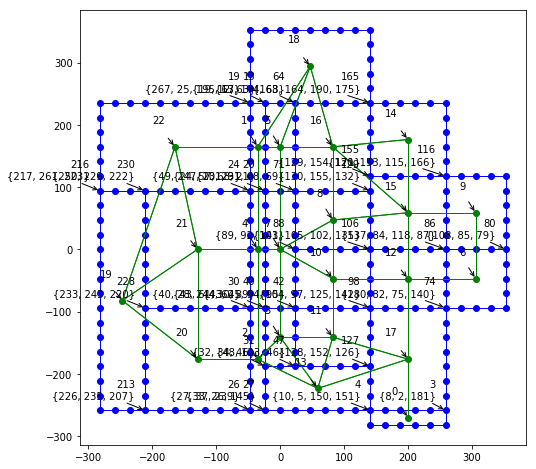

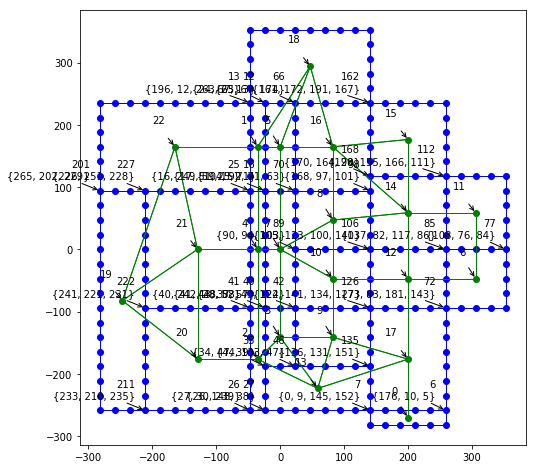

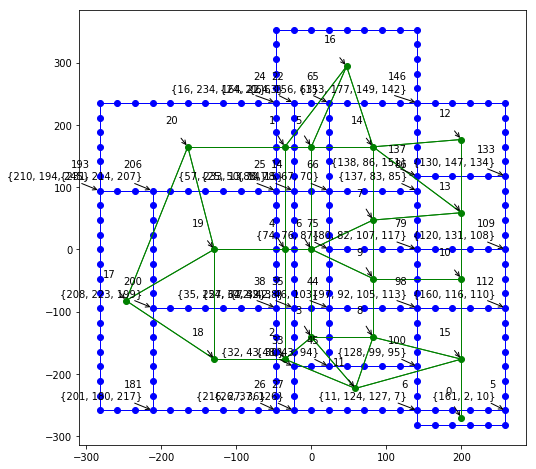

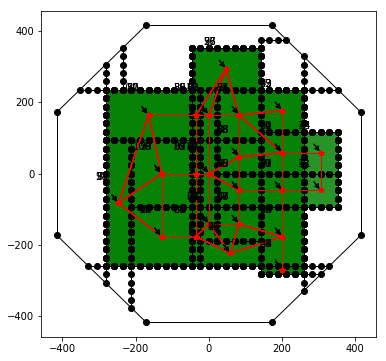

In [72]:
class Building:
    
    wallwidth = 1
    wallheight = 20
    doorwidth = 4
    doorheight = 12
    windowwidth = 6
    windowheight = 8
    

    @classmethod
    def specs(cls):
        {
            'quarters': {'leaf'},
            'garage': {'foyer'},
            'office': {},
            
        }
        
        required = ['foyer', 'leaf', 'leaf']
        optional = ['bedroom', 'office', 'garage']
                    
        # iteratively designate room functions to rooms
        # rooms have 0+ properties
        # {"leaf", "stem", "foyer", "shaft"}
        # "leaf" - connects only to adjacent stems
        # "stem" - connects to all adjacent stems and leafs
        #        - union of stems connects to all shafts
        # "foyer" - entrance/exit to exterior world
        # "shaft" - stem which connects multiple floors
    
    
    @classmethod
    def prune(cls, lg):
        """remove edges to create leafs where appropriate"""
        while True:
            for i, v in enumerate(lg.vertices):
                if v is not None:
                    
        
    
    @classmethod
    def plan(cls, rim):
        """create all information to generate the mesh"""
        lg = loop_chop(rim)
        top = cls.erode(lg, top=None, mode='peel', fraction=1.0)
        cls.prune(lg)
        #top = cls.erode(lg, top=top, mode='hollow', fraction=0.3)
        top = cls.grow(lg, top=top)
        top = cls.grow(lg, top=top)
        top = cls.erode(lg, top=top, mode='peel', fraction=0.5)
        top = cls.grow(lg, top=top)
        #top = cls.erode(lg, top=top, mode='peel', fraction=0.3)
        #top = cls.grow(lg, top=top)
        return lg
        
        
    @staticmethod
    def erode(lg, top=None, mode=None, fraction=1.0, contiguous=True):
        """use clever sampling to iteratively/randomly/contiguously remove vertices
        from a loop_graph output (i.e. planargraph with loop/adjacency data per vertex)"""
        if top is None:
            top = [i for i, v in enumerate(lg.vertices) if v is not None]
        N = len(lg.vertices)
        prob = np.ones((N, ))
        for i, v in enumerate(lg.vertices):
            if v is None or i not in top:
                prob[i] = 0
            # peel - remove only some of the boundary
            elif mode == 'peel' and not v.properties['boundary']:
                prob[i] = 0
            # hollow - remove only some of the non-boundary
            elif mode == 'hollow' and v.properties['boundary']:
                prob[i] = 0
        n = int(fraction * len(np.where(prob > 0)[0]))
        if contiguous:
            c = np.random.choice(N, p=(prob / prob.sum()))
            prob[c] = 0
            masked_prob = np.zeros(prob.shape)
            for i in lg.rings[c]:
                masked_prob[i] = prob[i]
            lg.rv(c)
            for i in range(1, n):
                if masked_prob.max() == 0:
                    break
                c = np.random.choice(N, p=(masked_prob / masked_prob.sum()))
                prob[c] = 0            
                masked_prob[c] = 0            
                for i in lg.rings[c]:
                    masked_prob[i] = prob[i]
                    assert (lg.vertices[i] is not None)
                lg.rv(c)
                #top.remove(c)
        else:
            for i in np.random.choice(N, size=n, replace=False, p=(prob / prob.sum())):
                lg.rv(i)
                #top.remove(i)
        return top

                
    @classmethod
    def grow(cls, lpg, top=None, dz=20):
        """extend a loop graph vertically"""
        
        for i, v in enumerate(lpg.vertices):
            if v is not None:
                shafts = [i]
        
        # use lg of previous floors to create lg for next floor
        edges = []
        for i, v in enumerate(lpg.vertices):
            if v is not None and (top is None or i in top):
                layers = cls.room(lpg, i)
                loop, ewalls, iwalls, floor = layers[-1]
                edges.extend(ewalls)
                edges.extend(iwalls)
                #if i in shafts:
                #    edges.extend(list(slide(list(loop), 2)))
        edges = [
            (lpg.source.vertices[u] + (vec3.Z() * dz),
             lpg.source.vertices[v] + (vec3.Z() * dz)) for u, v in edges]
        pg = proceduralgraph(lpg.source.fd, segs=edges)
        lg = pg.loop_graph()

        # combine the new lg with the existing one
        svmap, semap = lpg.source.merge(lg.source)
        lvmap, lemap = lpg.merge(lg)
        for i, j in lvmap.items():
            loops = lpg.vertices[j].properties.get('loops', []) 
            for k in range(len(loops)):
                loops[k] = [svmap[l] for l in loops[k]]
        for i, j in lemap.items():
            lpg.edges[j][2]['seam'] = [(svmap[u], svmap[v]) for u, v in lpg.edges[j][2]['seam']]

        for i in shafts:
            shaftloop = lpg.vertices[i].properties.get('loops', [])[0]
            shaftloop = [lpg.source.vertices[l] for l in shaftloop]
            shaftcom = vec3.com(shaftloop)
            for _, j in lvmap.items():
                loop = lpg.vertices[j].properties.get('loops', [])[0]
                loop = [lpg.source.vertices[l] for l in loop]
                loopcom = vec3.com(loop)
                if shaftcom.xy().isnear(loopcom.xy()):
                    lpg.ne(i, j, shaft=True)
                    break
            
        f, ax = plot()
        plot_pg(ax, pg, lw=1, mk='o', col='b')
        plot_pg(ax, lg, lw=1, mk='o', col='g')
                
        return set(lvmap.values())


    @classmethod
    def mesh(cls, lg, mesh=None):
        """create mesh geometry of structure"""
        mesh = trimesh() if mesh is None else mesh
        for i, v in enumerate(lg.vertices):
            if v is not None:
                layers = cls.room(lg, i)
                for loop, exterior_walls, interior_walls, floor in layers:
                    efloor, ifloors = floor
                    efloor = [lg.source.vertices[l] for l in efloor]
                    efloor = loop_offset(efloor, cls.wallwidth)
                    ifloors = [[lg.source.vertices[l] for l in ifloor] for ifloor in ifloors]
                    ifloors = [loop_offset(ifloor, -cls.wallwidth) for ifloor in ifloors]
                    if len(ifloors) == 1 and ifloors[0] == efloor:
                        print('shaft!')
                    else:
                        mesh.apy((efloor, ifloors))
                    for u, v in interior_walls:
                        cls.awall(mesh, loop, efloor, u, v, interior=True)
                    for u, v in exterior_walls:
                        cls.awall(mesh, loop, efloor, u, v, interior=False)
        return mesh
    
    
    @staticmethod
    def wall(x, y, wallwidth, wallheight,
             doorwidth=None, doorheight=None, windowwidth=None, windowheight=None):
        loop = [x.cp()]
        if doorwidth is not None:
            l = x.d(y)
            d = doorwidth / (2.0 * l)
            u = x.lerp(y, 0.5 - d)
            v = x.lerp(y, 0.5 + d)
            p = u + (vec3.Z() * doorheight)
            q = v + (vec3.Z() * doorheight)
            loop.append(u)
            loop.append(p)
            loop.append(q)
            loop.append(v)
        loop.extend([y.cp(), y + (vec3.Z() * wallheight), x + (vec3.Z() * wallheight)])
        return (loop, ())

    
    @classmethod
    def awall(cls, mesh, loop, floor, u, v, interior=True):
        x, y = floor[loop.index(u)], floor[loop.index(v)]                
        w = y + (vec3.Z() * cls.wallheight)
        z = x + (vec3.Z() * cls.wallheight)
        if interior:
            wall = cls.wall(x, y,
                cls.wallwidth, cls.wallheight,
                cls.doorwidth, cls.doorheight,
                cls.windowwidth, cls.windowheight)
        else:
            wall = cls.wall(x, y,
                cls.wallwidth, cls.wallheight / 2,
                None, cls.doorheight,
                cls.windowwidth, cls.windowheight)
        mesh.apy(wall)


    @staticmethod
    def room(pg, i):
        layers = []
        lg_v = pg.vertices[i]
        for loop in lg_v.properties['loops']:
            exterior_walls = set([tuple(x) for x in slide(list(loop), 2)])
            interior_walls = set()
            floor = (loop, ())
            for j in pg.rings[i]:
                _, _, e = pg.edges[pg.edge_lookup[((i, j) if (i < j) else (j, i))]]
                if e.get('shaft', False):
                    #floor = (loop, (loop, ))
                    floor = (loop, ())
                for interior_wall in e.get('seam', ()):
                    if interior_wall in exterior_walls:
                        exterior_walls.remove(interior_wall)
                        interior_walls.add(interior_wall)
            
            # iteratively designate room functions to rooms
            # rooms have 0+ properties
            # {"leaf", "stem", "foyer", "shaft"}
            # "leaf" - connects only to adjacent stems
            # "stem" - connects to all adjacent stems and leafs
            #        - union of stems connects to all shafts
            # "foyer" - entrance/exit to exterior world
            # "shaft" - stem which connects multiple floors
            
            # building configuration
            #  n_foyer
            #  n_shaft
            #  mandatories
            #  remainders
            # house
            #  2
            #  2
            #  garage, kitchen, bedroom, bathroom
            # room configuration
            #  wallwidth
            #  
            
            # design doors for selected interior walls
            # design floors and ceilings
            # additional loops can be floor doors, ceilings?
            # design windows for exterior walls
            
            layers.append((loop, exterior_walls, interior_walls, floor))
        return layers


class Sandbox(Config):
    """sandbox for making an interesting building"""


    def worldly(self):
        config = self.keeps
        # use one mesh obj for the online viewer?
        mesh = trimesh()
        # add terrain and sea
        origin, radius = vec3.O(), 500
        deltaz = radius / 4
        height = config.get('terrain', lambda p: 0)
        sealevel = config.get('sealevel', 0.0)        
        #self.terrain_mesh(origin, radius, sealevel, deltaz, height, mesh=mesh)
        Building.mesh(config['lg'], mesh=mesh)
        models = (model().add(mesh, 'default'), )
        return models

            
    def display(self, lg):
        f, ax = plot(figsize=(6, 6))
        plot_pg(ax, lg.source, lw=1, annotate=False)
        plot_pg(ax, lg, mk='*', lw=1, col='r', annotate=True)        
        for v in lg.vertices:
            if v is not None:
                loop = [lg.source.vertices[i] for i in v.properties['loops'][0]]
                ax.fill([p.x for p in loop], [p.y for p in loop], 'g', alpha=0.6)
        return self

    
    def __call__(self):
        rim = [r.cp() for r in self.rim]
        lg = Building.plan(rim)
        self.keeps = dict(lg=lg)
        self.display(lg)


box = Sandbox()
box()

prefix = './disposable/'
textures = {'default': './resources/textures/orangeboxtex.png'}
obj_world(prefix, box.worldly(), textures)

In [ ]:
l = [vec3(-142.1088, -46.0363, 0.0000), vec3(-142.1088, -23.5181, 0.0000), vec3(-142.1088, -1.0000, 0.0000), vec3(-164.6269, -1.0000, 0.0000), vec3(-188.1451, -1.0000, 0.0000), vec3(-211.6632, -1.0000, 0.0000), vec3(-235.1813, -1.0000, 0.0000), vec3(-257.6995, -1.0000, 0.0000), vec3(-257.6995, -23.5181, 0.0000), vec3(-257.6995, -46.0363, 0.0000), vec3(-235.1813, -46.0363, 0.0000), vec3(-211.6632, -46.0363, 0.0000), vec3(-188.1451, -46.0363, 0.0000), vec3(-164.6269, -46.0363, 0.0000)]
loop_normal(l)

In [ ]:
py = (
    #[vec3(-30.5611, -87.5867, 103.3172), vec3(-73.8089, 19.8026, 103.3172),
    # vec3(-78.9916, 0.4857, 103.3172), vec3(-35.7437, -106.9036, 103.3172)],
    [vec3(0, -80, 0), 
     #vec3(0, -70, 0), 
     vec3(0, 20, 0),
     vec3(-5, 0, 0), vec3(-5, -80, 0)],
    ()
)

f, ax = plot()
plot_loop(ax, py[0], lw=1, mk='o')

In [ ]:
from meshmaker.delaunay import triangulation

#py = (vec3(0, 0, 10).ring(8, 8), (vec3.O().ring(4, 5), ))
'''
py = (
    #[vec3(-30.5611, -87.5867, 103.3172), vec3(-73.8089, 19.8026, 103.3172),
    # vec3(-78.9916, 0.4857, 103.3172), vec3(-35.7437, -106.9036, 103.3172)],
    [vec3(-25, -80, 0), vec3(-73, 19, 0),
     vec3(-78, 0, 0), vec3(-35, -106, 0)],
    ()
)
'''
#for p in py[0]:
#    p.z -= 103.3172
    
f, ax = plot()
plot_loop(ax, py[0], lw=1, mk='o')

for u, v, w in slide(py[0], 3):
    a = (u - v).ang((w - v))
    print(a * 180 / np.pi)

e, h, r = 0.00001, 2, 1000

hmin, py = triangulation.chewfirstedges(py, e, h)
t = triangulation.delaunayedges(py, e)

plot_loop(ax, t[0], lw=1, mk='o')

#f, ax = plot()
#t.plot(ax=ax)
#for x in t.simplices():
#    print(x)

In [ ]:
def sandbox():
    config = Config()
    
    pg = proceduralgraph(None, segs=slide(config.rim, 2))
    fd = vec3_field([
        vec3_field.radial(vec3(0, 0, 0), 0.001, 1.0),
    ])
    lt = loop_tree(config.rim, field=fd)

    pg.fd = lt.piecewise_field

    tips = [vec3.O()]
    pg.layer += 1
    pg.inset(config.rim, (), config.dl, tips=tips, max_steps=30, fork_prob=0.2, max_depth=1)

    #pg.minlen(4)
    pg.minlen(3)
    eloop, loops = pg.polygon()
    loops = [loop_smooth(l, weight=0.5, iterations=2) for l in loops]
    terrain = config.terrain(loops)

    fps, _, _ = segment_regions(terrain.img > config.scaled_sealevel)
    fps = [config.itow.transform(fp) for fp in fps]
    for fp in fps:
        fd = vec3_field([
            vec3_field.radial(vec3.com(fp), 0.01, 1.0),
        ])
        nl = lt.av(fp, layer='shore', field=fd)




    ff = pg.fork_field()
    hf = height_field(config.origin, config.radius, config.pixels_per_world_unit, loops,
                      noise=False, prox_f=(lambda d: (2 * config.radius) - abs(min(d, 0)) ** 0.8))    
    df = lambda p: ff(p) * hf(p)

    mask = (lambda p: not p.inbxy(config.rim, False))    
    weights = pg.get_vertex_weights(df, n_best=25, mask=mask, layer=pg.layer)

    # THIS FUCKING BULL SHIT IS FAILING BECAUSE OF NUMERICAL FUCKING BULL SHIT
    # THIS FUCKING BULL SHIT IS FAILING BECAUSE OF NUMERICAL FUCKING BULL SHIT
    # THIS FUCKING BULL SHIT IS FAILING BECAUSE OF NUMERICAL FUCKING BULL SHIT
    # THIS FUCKING BULL SHIT IS FAILING BECAUSE OF NUMERICAL FUCKING BULL SHIT
    #tips = [x for x, w in enumerate(weights) if not isnear(w, 0)]
    # [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
    tips = [int(x) for x in np.random.choice(len(weights), p=weights, size=5)]
    print(tips)


    #shed_fd = []
    pg.layer += 1
    for tip in tips:
        p = pg.vertices[tip]
        ring = [pg.vertices[o] for o in pg.rings[tip]]
        if len(ring) == 1:
            tn = (p - ring[0]).nrmd()
        elif len(ring) == 2:
            tn = ((p - ring[0]).nrmd() + (ring[1] - p).nrmd()).nrmd()
        else:
            raise
        #nm = vec3.Z().crs(tn)
        #alpha = vec3.X().saxy(nm)
        
        #pg.fd = vec3_field.edge(p - tn * 1000, p + tn * 1000, 0.0, 1.0)
        pg.fd = vec3_field.edge(p + (tn * 1000), p - (tn * 1000), 0.0, 1.0)

        
        newtip = pg.trace(config.dl / 10.0, 10, tip,  0.0 , eb=config.rim, ibs=fps, debug=True)
        if newtip < 0:
            print('end trace1: {}'.format(newtip))

        newtip = pg.trace(config.dl / 10.0, 10, tip, np.pi, eb=config.rim, ibs=fps, debug=True)
        if newtip < 0:
            print('end trace2: {}'.format(newtip))
        
        
        #shed_fd.append(vec3_field.edge(u, p, 0.001, 1.0))
        #shed_fd.append(vec3_field.edge(p, v, 0.001, 1.0))
    #pg.fd = vec3_field(shed_fd)
    #pg.inset(config.rim, fps, config.dl / 5.0,
    #         tips=[(pg.vertices[tip],   0.0       ) for tip in tips] +\
    #              [(pg.vertices[tip],  np.pi      ) for tip in tips] +\
    #              [(pg.vertices[tip],  np.pi / 2.0) for tip in tips] +\
    #              [(pg.vertices[tip], -np.pi / 2.0) for tip in tips],
    #         max_steps=60, fork_prob=0.0, max_depth=1)


    
    config.keeps = {}
    config.keeps['pg'] = pg
    config.keeps['lt'] = lt
    config.keeps['sealevel'] = config.scaled_sealevel
    config.keeps['terrain'] = config.terrain
    config.keeps['docks'] = [pg.vertices[tip] for tip in tips]
    return config


config = sandbox()

In [ ]:
np.pi * 2

In [ ]:
def display(pg, lt):
    #f, ax = plot(figsize=(6, 6))
    #lt.plot(ax)
    
    f, ax = plot(figsize=(6, 6))
    
    #lt.plot(ax)
    #return

    colors = dict(shore='y', sand='g', rural='r', urban='m')
    
    rim = lt.loop
    ax.fill([p.x for p in rim], [p.y for p in rim], 'b', alpha=0.2)
    plot_loop(ax, rim, col='r', lw=2)
    
    for i, landmass in enumerate(lt.children):
        coast = landmass.loop
        ax.fill([p.x for p in coast], [p.y for p in coast], colors[landmass.layer], alpha=0.5)
        
        #plot_loop(ax, coast, col='b', lw=1)
        #plot_point(ax, vec3.com(coast), col='k', mk='*', annotation=f'lm{i:02d}')

        for c in landmass.children:
            if c.layer == 'sand':
                ax.fill([p.x for p in c.loop], [p.y for p in c.loop], colors[c.layer], alpha=0.6)

            for feature in c.children:
                loop, color = feature.loop, colors[feature.layer]
                print('featurelayer', feature.layer, color)
                ax.fill([p.x for p in loop], [p.y for p in loop], color, alpha=1.0)

                for leature in feature.children:
                    loop, color = leature.loop, colors[leature.layer]
                    print('leaturelayer', leature.layer, color)
                    ax.fill([p.x for p in loop], [p.y for p in loop], color, alpha=1.0)

    plot_pg(ax, pg, mk='o', lw=2, annotate=False)
    
    for j, p in enumerate(config.keeps['docks']):
        plot_point(ax, p, col='r', mk='s', annotation='dock %d' % j)
                    
display(config.keeps['pg'], config.keeps['lt'])

# #####

    pathing -> pick two points -> pick optimal point on midline between them -> repeat ad nauseum for subunits
    

In [ ]:
from meshmaker.model import model


def worldly(config):
    config = config.keeps
    
    origin, radius = vec3.O(), 500
    deltaz = radius / 4
    
    height = config.get('terrain', lambda p: 0)
    sealevel = config.get('sealevel', 0.0)

    print(sealevel, deltaz, sealevel * deltaz)
    
    mesh = trimesh()
    
    triangles = origin.fan(radius, 6)
    for u, v, w in triangles:
        u = vec3(u.x, u.y, sealevel * deltaz)
        v = vec3(v.x, v.y, sealevel * deltaz)
        w = vec3(w.x, w.y, sealevel * deltaz)
        mesh.af(u, v, w)
    for i in range(6):
        triangles = subdivide_triangles(triangles)
    for u, v, w in triangles:
        u.set(u.x, u.y, height(u) * deltaz)
        v.set(v.x, v.y, height(v) * deltaz)
        w.set(w.x, w.y, height(w) * deltaz)
        mesh.af(u, v, w)
    
    models = (model().add(mesh, 'default'), )
    return models

In [ ]:
from meshmaker.obj import obj_world


prefix = './disposable/'
models = worldly(config)
textures = {'default': './resources/textures/orangeboxtex.png'}
obj_world(prefix, models, textures)

# JUNK 

In [ ]:
keeps = {}


def river_field(rim):
    n = len(rim) // 2
    ps = np.random.choice(rim, size=n)
    ds = np.random.randn(n) * 0.0001 + 0.001
    ws = np.ones(n)
    es = [vec3_field.radial(p, d, w) for p, d, w in zip(ps, ds, ws)]
    fd = vec3_field(es)
    return fd


def landmass_field(landmass, terrain):
    es = [
        vec3_field.grid(vec3.O(), vec3.X(), 0.0, 0.01),
        vec3_field.loop(landmass.loop, 0.1, 0.1),
        vec3_field.topography(terrain, 1.0),
    ]
    fd = vec3_field(es)
    return fd


def county_field(county, terrain):
    es = [
        vec3_field.grid(vec3.O(), vec3.Y(), 0.0, 0.1),
        vec3_field.topography(terrain, 0.1),
    ]
    for lake in county.children:
        assert lake.shore
        es.append(vec3_field.loop(lake.loop, 0.001, 0.1))
    fd = vec3_field(es)
    return fd


def first_road_layer(eb, pg, lt):

    mask = None if eb is None else (lambda p: not p.inbxy(eb, True))
    
    field = self.fork_field()
    weights = pg.get_vertex_weights(field, n_best=5, mask=mask)
    tip = np.random.choice(len(weights), p=weights)


def test():
    np.random.seed(config.seed)

    print('generating continent layer')
    rim = config.origin.ring(config.radius - 50, 8)

    pg = proceduralgraph(None, segs=slide(rim, 2))
    rf = river_field(rim)
    lt = loop_tree(rim, field=rf)

    p, q = bbox(rim)
    dl = (q - p).mag() / 10


    print(f'generating river layer (dl: {dl})')
    tips = np.random.choice(rim, size=np.random.randint(2, len(rim) // 2))
    #rf = river_field(rim)
    #pg.fd = river_field(rim)
    pg.fd = lt.piecewise_field
    pg.layer += 1
    pg.inset(rim, (), dl, tips=tips, max_steps=30, fork_prob=0.2, max_depth=1)


    print(f'generating terrain (pg.minlen: {pg.minlen(4)})')
    eloop, loops = pg.polygon()
    for i in range(2):
        loops = [loop_smooth(l, weight=0.5) for l in loops]
    terrain = height_field(config.origin, config.radius, config.pixels_per_world_unit, loops)


    print('generating loop tree layers')
    itow = tform(vec3.U().xy() * -config.radius, None, vec3(2 * config.radius, 2 * config.radius, 0))
    z0, dz = terrain.img.min(), terrain.img.max() - terrain.img.min()


    print('  generating the shore lines')
    sealevel = z0 + config.sealevel * dz
    fps, _, _ = segment_regions(terrain.img > sealevel)
    for fp in fps:
        # TODO: SET THIS FIELD TO INLAND APPROPRIATE
        nl = lt.av(itow.transform(fp), layer='shore', field=None)


    print('  generating the sand lines')
    sandlevel = z0 + config.sandlevel * dz
    fps, masks, _ = segment_regions(terrain.img > sandlevel)
    for fp in fps:
        # TODO: SET THIS FIELD TO INLAND APPROPRIATE
        nl = lt.av(itow.transform(fp), layer='sand', field=None)


    print('  generating the rural lines')
    mask = sum(masks)
    grad = steepness(terrain.img * mask)
    #mask = mask & (grad < (0.5 / np.sqrt(2)))
    mask = mask & (grad < np.percentile(grad[mask > 0], 68))
    fps, masks, regions = segment_regions(mask)
    fps, _ = zip(*sorted(zip(fps, regions), key=lambda i: i[1].area, reverse=True))
    for i, fp in enumerate(fps):
        if i < config.n_cities:
            # TODO: SET THIS FIELD TO INLAND APPROPRIATE
            nl = lt.av(itow.transform(fp), layer='rural', field=None)
        else:
            break


    print('  generating the urban lines')
    mask = sum(masks)
    grad = steepness(terrain.img * mask)
    #mask = mask & (grad < (0.5 / np.sqrt(2)))
    mask = mask & (grad < np.percentile(grad[mask > 0], 68))
    fps, masks, regions = segment_regions(mask)
    fps, _ = zip(*sorted(zip(fps, regions), key=lambda i: i[1].area, reverse=True))
    for i, fp in enumerate(fps):
        if i < config.n_cities:
            # TODO: SET THIS FIELD TO INLAND APPROPRIATE
            nl = lt.av(itow.transform(fp), layer='urban', field=None)
        else:
            break
    
    
    #print('generating first road layer')
    #first_road_layer(rim, pg, lt)

    #pg.fd = county_field(lt, terrain)
    #pg.inset(rim, (), dl, tips=tips, max_steps=30, fork_prob=0.2, max_depth=1)
    

    print('play for keeps')
    keeps['rim'] = rim
    keeps['sealevel'] = sealevel
    keeps['sandlevel'] = sandlevel
    keeps['terrain'] = terrain
    keeps['pg'] = pg
    keeps['lt'] = lt
    

#prun test(terrain)
test()

In [ ]:
from meshmaker.plt import plot, plot_pg, plot_loop


def loop_aggregate(loop, radius, alpha=None):
    assert len(loop) > 3, 'loops require 4+ vertices to aggregate'
    
    edges = [radius < (v - u).mag() for u, v in slide(loop, 2)]
    assert edges.count(True) > 2, 'nothing would be left after aggregate'
    
    piece = []
    newloop = []
    for u, v, w in slide(loop, 3):
        #print((v - u).mag(), (w - v).mag())
        if (v - u).mag() < radius or (w - v).mag() < radius:
            piece.append(v)
        elif alpha and (u - v).saxy(w - v) < alpha:
            piece.append(v)
        #else:
        if piece:
            newloop.append(vec3.com(piece))
            piece = []
        else:
            newloop.append(v)
    return newloop
    
def test():
    
    loop = vec3.O().ring(4, 32)
    reloop = loop_aggregate(loop, 4)
    
    f, ax = plot(figsize=(8, 8))
    plot_loop(ax, loop, col='g', lw=8)
    plot_loop(ax, reloop, col='b')
    
test()

In [ ]:
def loop_diagonals(loop):
    diagonals = {}
    for i in range(len(loop)):
        u = loop[i]
        for j in range(len(loop)):
            #if abs(i - j) > 1:
            if (i - j) > 1:
                v = loop[j]
                diagonals[(i, j)] = (u, v)
    return diagonals


def loop_diagonal_lengths(loop):
    diagonals = loop_diagonals(loop)
    lengths = [(v - u).mag() for u, v in diagonals.values()]
    return lengths